# Titanic model using ensemble modeling and Pipeline


### This script follows three main parts:


- Feature analysis
- Feature engineering / Preprocessing 
- Modeling


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette=sns.color_palette('Set2'))

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier,VotingClassifier
from xgboost import XGBRFClassifier,XGBClassifier




## 1. Feature Analysis



### 1.1 Load the data


In [2]:
train_set=pd.read_csv('datasets/Titanic/train.csv')
test_set=pd.read_csv('datasets/Titanic/test.csv')

combined=[train_set,test_set]

### 1.2 Describing features

### Here we can describe all types of data in our dataset as below:

Categorical:

- Categorical: Survived, Sex, and Embarked
- Ordinal: Pclass

Numerical:

- Continous: Age, Fare

- Discrete: SibSp, Parch


In [2]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


- Survived: Target in our dataset, 0 means the passenger did not survive, while 1 means he/she survived.
- Pclass: passenger class.
- Name, Sex, Age: self-explanatory
- SibSp: how many siblings & spouses of the passenger aboard the Titanic.
- Parch: how many children & parents of the passenger aboard the Titanic.
- Ticket: ticket id
- Fare: price paid (in pounds)
- Cabin: passenger's cabin number
- Embarked: where the passenger embarked the Titanic

In [4]:
train_set.info()
print('_'*45)
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
_____________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pass

- Seven features are integer or floats. Six in case of test dataset.
- Five features are strings (object).

_Age_ , _Cabin_ and _Embarked_ attributes are sometimes null (less than 891 non-null) in the train set. 

 Also _Age_ , _Cabin_ and _Fare_ attributes have nulls (less than 418 non-null) in the test set.

In [5]:
train_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Total number of samples in the training set are 891.
- Around 38% samples survived.
- Most passengers did not travel with parents or children.
- Fares varied significantly with a mean of 32 and only few passengers paying as high as $512.
- The mean Age is 29 and less than 1% are 65-80.

In [6]:
train_set.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Sundman, Mr. Johan Julian",male,CA. 2343,G6,S
freq,1,577,7,4,644


### 1.3 Visualizing features

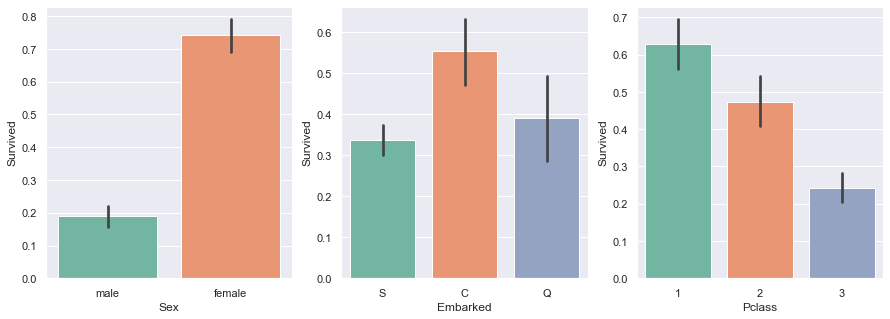

In [7]:
fig,axes=plt.subplots(1,3,squeeze=True,figsize=(15,5))
sns.barplot(x = 'Sex', y = 'Survived', data=train_set, ax =axes[0])
sns.barplot(x = 'Embarked', y = 'Survived', data=train_set, ax =axes[1])
sns.barplot(x = 'Pclass', y = 'Survived', data=train_set, ax =axes[2])


- We can see Sex=female had very high survival rate.
- Location embark 'C' had the highest surviving rate, after that 'Q' and at the end 'S'.
- Pclass 1 had the highest perecentage of surviving while Pcalss 3 had the least percentage. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000235D8D3B1C0>,
      dtype=object)

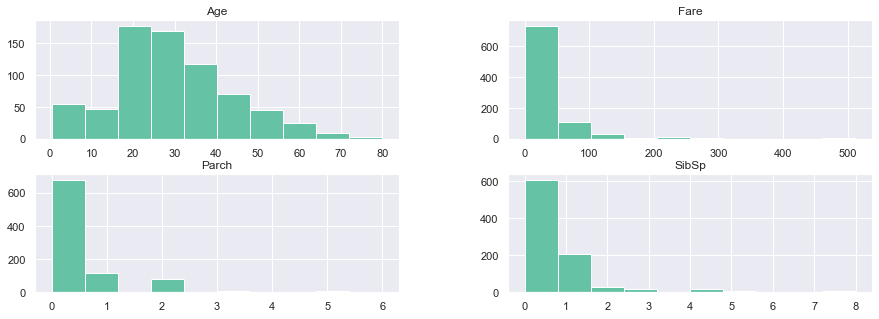

In [8]:
train_set[['Fare','Age','Parch','SibSp']].hist(figsize=(15,5))


Text(0.5, 1.0, 'Correlation On dataset')

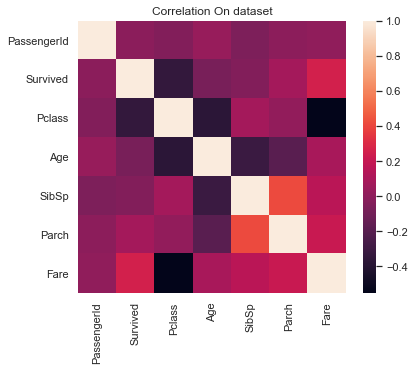

In [9]:
plt.figure(figsize=(6,5))
sns.heatmap(train_set.corr())
plt.title('Correlation On dataset')


Only Fare feature seems to have a significative correlation with the survival probability.



In [10]:
train_set[['Embarked','Survived']].groupby('Embarked', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


there is a strong correlation among Embarked=C and Survived

In [11]:
train_set[['Sex','Survived']].groupby('Sex', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Sex=female had very high survival rate at 74%.

In [12]:
train_set[['Pclass','Survived']].groupby('Pclass', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


there is a significant correlation (>0.5) among Pclass=1 and Survived

In [3]:
train_set[['Parch','Survived']].groupby('Parch', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [4]:
train_set[['SibSp','Survived']].groupby('SibSp', as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


_SibSp_ and _Parch_  features have zero correlation for certain values. It may be best to derive a single feature from both of these columns

## 2. Feature Engineering / Preprocessing

Here is were unnecessary features are removed from the data set or new features are derived from already existing features with low correlations.


In [13]:
for dataset in combined:
    dataset.drop(['Ticket','Cabin'],  axis=1, inplace=True)



columns _Ticket_ and _Cabin_ are dropped as they are very little or no correlation. 

In [14]:
Id=test_set[['PassengerId']]

_PassengerId_ is stored away as it will be only used in our final submission

In [15]:
X_train=train_set.drop('Survived',  axis=1)

y_train=train_set['Survived']

Here we separate the datas and target values from the training dataset as it will be used later for  modeling. 

### 2.1 Creating new features or extracting from existing

- replace SibSp and Parch with their sum, and creating a new Feature IsAlone that checks if the passenger is alone or with family.

- Creating a feature called Title that uses parts of names that correlate well with the Survived attribute.

- converting numerical attributes to categorical attributes such as: Age and Fare.

In [16]:


class FeatureEngineering(BaseEstimator,TransformerMixin):

    def fit(self,df,y=None):
        return self
    def transform(self,df):
        
        df['Fare'].fillna(df['Fare'].median(), inplace = True)   
        df['Embarked'].fillna("S", inplace = True)   
        df['Family']=df['SibSp']+df['Parch']
        
        def HasFamily(x):
            
            if x==0:
                return 1
            else:
                return 0
            
        df['IsALone']=df['Family'].apply(HasFamily)
        
        df.drop(['SibSp','Parch','Family','PassengerId'],inplace=True,axis=1)
        
        df['Name'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
        def Name_transform(X):
            if X=='Mr':
                return 'Mr'

            elif X=='Miss'or X=='Mlle' or X=='Ms':
                return 'Miss'

            elif X=='Mrs' or X=='Mme':
                return 'Mrs'

            elif X=='Master':
                return 'Master'

            else:
                return 'ect'
            
        df['Name']=df['Name'].apply(Name_transform)


        df['Age']=pd.cut(df['Age'],5,labels=[0.,1.,2.,3.,4.])

        df['Fare']=pd.qcut(df['Fare'],4,labels=[0.,1.,2.,3.])

        return df

### 2.2 Pipeline

Creating a PipeLine to prepare the train and test data for the modeling.

- The Null values in the _Age_ will be replaced by median using SimpleImputer.
- Categorical features such as: _Embarked_ , _Name_ and _Sex_ are encoded to ordinal values using OrdinalEncoder.
- At the end all the datas are scaled using StandardScaler.


In [17]:
cat_attir=['Embarked','Name','Sex']
num_attir=X_train[['Age']]



missing_pipeline = ColumnTransformer([
        ("num", SimpleImputer(strategy='median'),list(num_attir)),        
        ("Ordinal", OrdinalEncoder(),cat_attir),
   
    ],remainder='passthrough')


full_pipeline = Pipeline([
    
        ("Fe", FeatureEngineering()),
        ("p", missing_pipeline),
        ("Scale", StandardScaler()),
      
    ])


X_train_=full_pipeline.fit_transform(X_train)
test_set_=full_pipeline.transform(test_set)


## 3. Modeling

Here 10 different classifiers are compared and then mean accuracy of each of them are evaluated using cross valution score.

Classifiers used in comparison are listed as below:

- 1- KNeighborsClassifier
- 2- LogisticRegression
- 3- SVC
- 4- DecisionTreeClassifier
- 5- RandomForestClassifier
- 6- ExtraTreesClassifier
- 7- AdaBoostClassifier
- 8- GradientBoostingClassifier
- 9- XGBRFClassifier
- 10- XGBClassifier

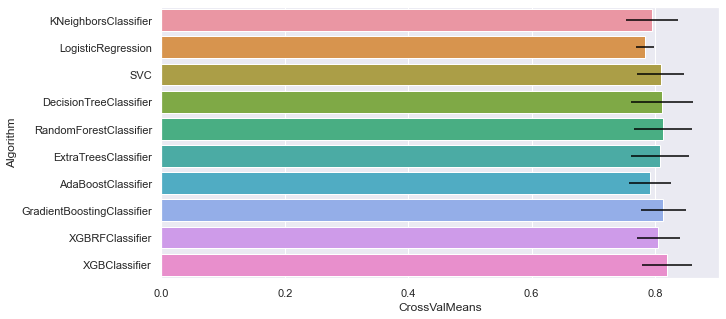

In [18]:
knn=KNeighborsClassifier()
log=LogisticRegression(random_state=42)
svc=SVC(random_state=42,probability=True)
dct=DecisionTreeClassifier(random_state=42)
rfc=RandomForestClassifier(random_state=42)
ext=ExtraTreesClassifier(random_state=42)
ada=AdaBoostClassifier(random_state=42)
grb=GradientBoostingClassifier(random_state=42)
xgb=XGBRFClassifier(random_state=42)
xgbc=XGBClassifier(random_state=42)

cv_scores=[]
scores_m=[]
std=[]
classifiers=[knn,log,svc,dct,rfc,ext,ada,grb,xgb,xgbc]

for cls in classifiers :
    cv_scores.append(cross_val_score(cls, X_train_, y_train, scoring = "accuracy", cv = 10))
    scores_mean=np.mean(cv_scores,axis=1)
    std=np.std(cv_scores,axis=1)




cv_results = pd.DataFrame({"CrossValMeans":scores_mean,"CrossValerrors": std,"Algorithm":["KNeighborsClassifier","LogisticRegression","SVC",
                        "DecisionTreeClassifier","RandomForestClassifier","ExtraTreesClassifier","AdaBoostClassifier","GradientBoostingClassifier",
                        "XGBRFClassifier","XGBClassifier"]})
fig,axes=plt.subplots(figsize=(10,5))
sns.barplot("CrossValMeans","Algorithm",data = cv_results, orient = "h",**{'xerr':std})


In the barplot above mean cross valution score of each of the classifiers are shown, the best performed are: Knn, SVC, DecisionTreeClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, XGBRFClassifier and XGBClassifier

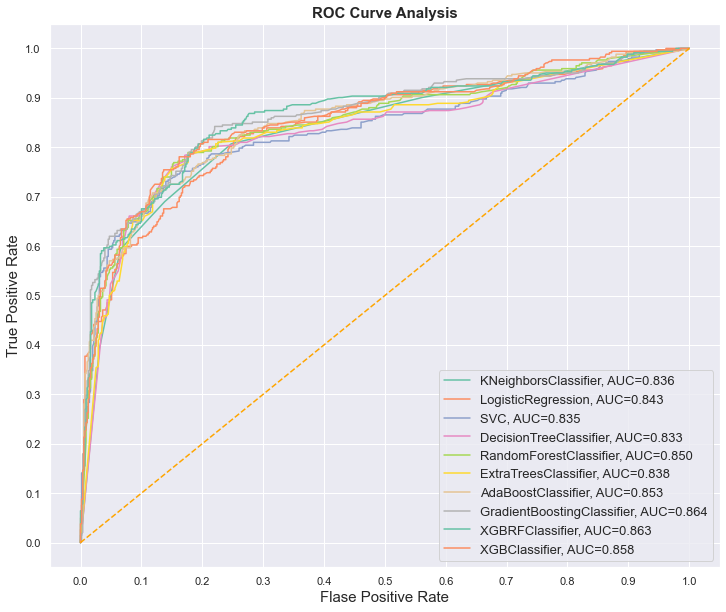

In [19]:

Proba_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for cls in classifiers:
    proba = cross_val_predict(cls, X_train_, y_train, cv=10, method="predict_proba")
    yproba=proba[::,1]
    fpr, tpr, _ = roc_curve(y_train,  yproba)
    auc = roc_auc_score(y_train, yproba)
    
    Proba_table = Proba_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
    
Proba_table.set_index('classifiers', inplace=True)


fig = plt.figure(figsize=(12,10))

for i in Proba_table.index:
    plt.plot(Proba_table.loc[i]['fpr'], 
             Proba_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, Proba_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In the ROC curve and AUC scores above more information about the precision of our classifiers are shown, according to cross_valution_score means and AUC scores only 5 classifiers has been chosen:

- SVC
- RandomForestClassifier
- GradientBoostingClassifier 
- XGBRFClassifier  
- XGBClassifier


### 3.1 hyperparameter tuning

Using GridSearchCV parameters for each of our 5 calssifiers are tuned.

#### RandomForestClassifier

In [20]:
param_grid = {"max_depth": [2,3,4,5],
              "n_estimators" :[100,200,300],
              "criterion": ['gini','entropy']}


grid = GridSearchCV(rfc,param_grid = param_grid, cv=10, scoring="accuracy", verbose = 1)

grid.fit(X_train_,y_train)

RFC_best = grid.best_estimator_

# Best score
grid.best_score_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.1min finished


0.8159550561797753

#### XGBClassifier

In [21]:

param_grid = {
        'n_estimators':[100,300],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.1,0.5, 1],
        'subsample': [0.5, 1.0],
        'colsample_bytree': [0.5, 1.0],
        'max_depth': [3, 4, 5]
             }   

grid = GridSearchCV(xgbc,param_grid = param_grid, cv=10, scoring="accuracy", verbose = 1)

grid.fit(X_train_,y_train)

xgbc_best = grid.best_estimator_

# Best score
grid.best_score_



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=1)]: Done 2160 out of 2160 | elapsed:  2.4min finished


0.8272284644194757

#### XGBRFClassifier

In [22]:
param_grid = {
        'n_estimators':[100,300],
        'max_depth':[3, 4, 5],
        'subsample': [0.5, 1.0],
        'colsample_bytree': [0.5, 1.0],
        'gamma':[0.1,0.5, 1]
                }   

grid = GridSearchCV(xgb,param_grid = param_grid, cv=10, scoring="accuracy", verbose = 1)

grid.fit(X_train_,y_train)

xgb_best = grid.best_estimator_

# Best score
grid.best_score_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:   35.8s finished


0.8238077403245943

#### GradientBoostingClassifier

In [23]:
param_grid = {
                'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

grid = GridSearchCV(grb,param_grid = param_grid, cv=10, scoring="accuracy", verbose = 1)

grid.fit(X_train_,y_train)

grb_best = grid.best_estimator_

# Best score
grid.best_score_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.1min finished


0.8260174781523096

#### SVC

In [24]:
param_grid = {
            'kernel': ['rbf' ], 
            'gamma': [ 0.001, 0.01, 0.1, 1],
            'C': [1, 10, 50, 100,200,300, 1000] ,
            
              }

grid = GridSearchCV(svc,param_grid = param_grid, cv=10, scoring="accuracy", verbose = 1)

grid.fit(X_train_,y_train)

svc_best = grid.best_estimator_

# Best score
grid.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:   36.4s finished


0.8136704119850187

#### AdaBoostClassifier

In [25]:
    
param_grid = {
                "base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[30,50,100,200,300],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]           
              }

ada_dct = AdaBoostClassifier(dct, random_state=41)

grid = GridSearchCV(ada_dct,param_grid = param_grid, cv=10, scoring="accuracy", verbose = 1)

grid.fit(X_train_,y_train)

ada_dct_best = grid.best_estimator_

# Best score
grid.best_score_

Fitting 10 folds for each of 280 candidates, totalling 2800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2800 out of 2800 | elapsed: 12.6min finished


0.8171660424469411

### 3.2 Feature importance of tree based classifiers
In order to see the most informative features for the prediction of passengers survival, the feature importance for the 4 tree based classifiers are calculated and tabled.

In [26]:
rfc_feature = RFC_best.feature_importances_
xgbc_feature = xgbc_best.feature_importances_
xgb_feature = xgb_best.feature_importances_
grb_feature = grb_best.feature_importances_
ada_dct_feature = ada_dct_best.feature_importances_

rfc_feature

D:\Programs\Anaconda\lib\site-packages\sklearn\tree\_classes.py:590: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


array([0.04465363, 0.04449583, 0.22027889, 0.37737857, 0.1858691 ,
       0.09026361, 0.03706037])

In [27]:
cols = X_train.columns.values


feature_dataframe = pd.DataFrame( {
    'features': cols,
     'Random Forest feature importances': rfc_feature,
     'XGBClassifier  feature importances': xgbc_feature,
      'XGBRFClassifier feature importances': xgb_feature,
        'Gradient Boost feature importances': grb_feature,
            'Ada feature importances': ada_dct_feature
    })

In [28]:
feature_dataframe

,features,Random Forest feature importances,XGBClassifier feature importances,XGBRFClassifier feature importances,Gradient Boost feature importances,Ada feature importances
0,Pclass,0.044654,0.113123,0.014318,0.015920,NaN
1,Name,0.044496,0.122115,0.035115,0.034665,0.097579
2,Sex,0.220279,0.112912,0.170982,0.206837,NaN
3,Age,0.377379,0.315312,0.647379,0.421998,NaN
4,Fare,0.185869,0.137129,0.102434,0.200744,NaN
5,Embarked,0.090264,0.099973,0.020094,0.093324,NaN
6,IsALone,0.037060,0.099436,0.009678,0.026512,NaN


In [29]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)

In [30]:
feature_dataframe

,features,Random Forest feature importances,XGBClassifier feature importances,XGBRFClassifier feature importances,Gradient Boost feature importances,Ada feature importances,mean
0,Pclass,0.044654,0.113123,0.014318,0.015920,NaN,0.047004
1,Name,0.044496,0.122115,0.035115,0.034665,0.097579,0.066794
2,Sex,0.220279,0.112912,0.170982,0.206837,NaN,0.177753
3,Age,0.377379,0.315312,0.647379,0.421998,NaN,0.440517
4,Fare,0.185869,0.137129,0.102434,0.200744,NaN,0.156544
5,Embarked,0.090264,0.099973,0.020094,0.093324,NaN,0.075914
6,IsALone,0.037060,0.099436,0.009678,0.026512,NaN,0.043171


Text(0.5, 0, 'Mean Feature Importance')

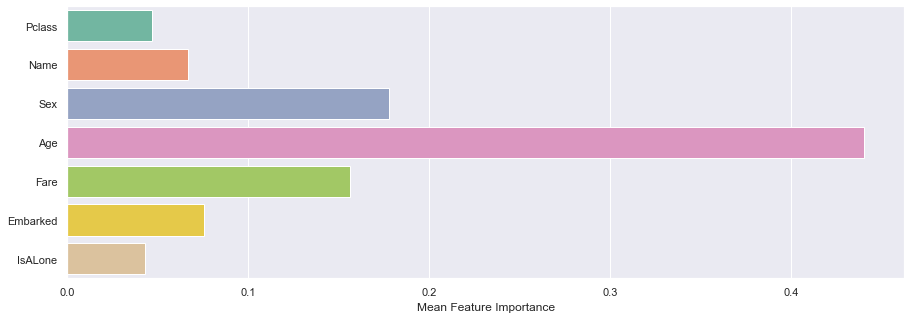

In [31]:
fig,axes=plt.subplots(figsize=(15,5))

sns.barplot(y=feature_dataframe['features'].values,x = feature_dataframe['mean'].values)
plt.xlabel("Mean Feature Importance",fontsize=12)

The above barplot is a visualisation of the mean feature importance in all the tree based classifiers. In this case _Age_ has the most importance.

### 3.3 Ensemble modeling


#### Combining models
Voting classifier is used to combine the predictions coming from the 5 classifiers.

This is a "soft" Voting classifier to take into account the probability of each vote.

In [32]:

models=[
        ('rfc', RFC_best),
        ('xgbc', xgbc_best), 
        ('xgb',xgb_best),
        ('grb', grb_best),
        ('svc', svc_best),
        ('ada', ada_dct_best)   
]

voting_Classifier = VotingClassifier(estimators=models, voting='soft', n_jobs=1)

voting_Classifier.fit(X_train_, y_train)

score=cross_val_score(voting_Classifier,X_train_,y_train,cv=10)
score_mean=score.mean()
score_mean

0.8159550561797753

### 3.4 Prediction and sumission of results.


In [33]:
test_Survived = pd.Series(voting_Classifier.predict(test_set_), name="Survived")
results = pd.concat([Id,test_Survived],axis=1)
results.to_csv("ensemble_titanic.csv",index=False)